## Reading all masks from the folders and producing one single mask file

In [46]:
import cv2
import glob
import numpy as np
DATA_DIR = "./input"
split = 'names'

from __future__ import print_function, division
import os
import pandas as pd
import skimage
import random
import skimage.io
from skimage import transform
from skimage.viewer import ImageViewer
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure
import cv2
import glob


def read_from_file(list_file, comment='#'):
    with open(list_file) as f:
        lines  = f.readlines()
    strings=[]
    for line in lines:
        s = line.split(comment, 1)[0].strip()
        if s != '':
            strings.append(s)
    return strings
        
def combining_masks():
    ids = read_from_file(DATA_DIR + '/names/' + split, comment='#')
    num_ids = len(ids)
    for i in range(num_ids):
        id = ids[i]
        image_files = glob.glob(DATA_DIR + '/' + id + '/images/*.png')
        image_file=image_files[0]
        image = cv2.imread(image_file,cv2.IMREAD_COLOR)
        H,W,C = image.shape
        one_mask = np.zeros((H,W), dtype=bool)
        mask_files =glob.glob(DATA_DIR + '/' + id + '/masks/*.png')
        for mask_file in mask_files:
            mask = cv2.imread(mask_file,cv2.IMREAD_GRAYSCALE)
            one_mask = one_mask |(mask>128)
        one_mask = (one_mask*255).astype(np.uint8)
        cv2.imwrite(DATA_DIR + '/' + id + '/mask.png', one_mask)


In [47]:
combining_masks()

## All random data augmentations in one function

In [48]:
def data_aug(image,label,angel=5,resize_rate=0.3, output_size=256):

    flip = random.randint(0, 1)
    size = image.shape[0]
    sh = random.random()/2-0.25
    rotate_angel = random.random()/180*np.pi*angel
    sigma = random.uniform(0,0.6)
    scaling = random.uniform(0.1,1)
    
    # Rescale
    transform.rescale(image, scaling, mode='reflect')
    transform.rescale(label, scaling, mode='reflect')   
        
    # Create affine transform
    afine_tf = transform.AffineTransform(shear=sh,rotation=rotate_angel)
    
    # Apply transform to image data
    image = transform.warp(image, inverse_map=afine_tf,mode='edge')
    label = transform.warp(label, inverse_map=afine_tf,mode='edge')
    
    # Ramdomly flip frame
    if flip:
        image = image[:,::-1,:]
        label = label[:,::-1]
        
    #Shuffle the RGB channels to get color invariance
    p = [0,1,2]
    random.shuffle(p)
    image[:,:,:] = image[:,:,p]    
    #Change exposure/intensity randomly:
    imageAlp = image[:,:,2]  
    imageRest = image[:,:,0:3]
    if random.randint(0,1)==0:
        #use clahe
        image = exposure.equalize_adapthist(image)    
    if random.randint(0,1)==0:
        image = exposure.rescale_intensity(image,(0,random.uniform(0.5,1)))        
    
    #Rotate the image
    rotate = random.randint(0,3)
    image = transform.rotate(image, rotate*np.pi/2, mode='reflect')
    label = transform.rotate(label, rotate*np.pi/2, mode='reflect')

    #Corrupt data a little
    if sigma > 0:
        image = np.minimum(np.maximum(0.0,image + np.random.normal(0, sigma, image.shape)/255.0),255.0)
    
    
    # Randomly cropping image frame
    rsize = random.randint(np.floor(resize_rate*size),size)
    w_s = random.randint(0,size - rsize)
    h_s = random.randint(0,size - rsize)
    image = image[w_s:w_s+size,h_s:h_s+size,:]
    label = label[w_s:w_s+size,h_s:h_s+size]
    
    
    #Now we resize the image
    image = transform.resize(image, (output_size, output_size))
    label = transform.resize(label, (output_size, output_size))
    image = image.transpose(2, 1, 0)
    #label  = cv2.threshold(label, 128, 255, cv2.THRESH_BINARY)[1]
    label[label > 0.] = 1
    return image.astype(float), label.astype(float)


## Creating Dataset to use it in DataLoader

In [49]:
from torch.utils.data.dataset import Dataset

class ImageMaskDataset(Dataset):

    def __init__(self, split, mode='train', transform= None):
        super(ImageMaskDataset, self).__init__()
        self.split = split
        self.mode = mode
        self.transform = transform
        ids = read_from_file(DATA_DIR + '/names/' + split, comment='#')
        self.ids = ids

    def __getitem__(self, index):
        id   = self.ids[index]
        name = id.split('/')[-1]
        image_file = DATA_DIR + '/' + id + '/images/' + name +'.png'
        image = cv2.imread(image_file, cv2.IMREAD_COLOR)

        if self.mode in ['train']:
            mask_file =  DATA_DIR + '/' + id + '/mask.png'
            mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
            return self.transform(image,mask)

        if self.mode in ['test']:
            return self.transform(image)

    def __len__(self):
        return len(self.ids)

#### Function for image visualisation

In [50]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import *
def image_show(name, image, resize=1):
    H,W = image.shape[0:2]
    cv2.namedWindow(name, cv2.WINDOW_NORMAL)
    cv2.imshow(name, image.astype(np.uint8))
    cv2.resizeWindow(name, round(resize*W), round(resize*H))

#### Simple data augmentation for testing

In [51]:
WIDTH = 256
HIGHT =256
def simple_augment(image,mask):
        image = cv2.resize(image,(WIDTH,HIGHT))
        image = image.transpose(2, 1, 0)
        mask  = cv2.resize(mask,(WIDTH,HIGHT))
        mask  = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)[1]
        mask[mask == 255.] = 1
        return image.astype(float),mask.astype(float)

dataset = ImageMaskDataset(
        'names', mode='train', transform = data_aug
    )
sampler = RandomSampler(dataset)

In [52]:
dataset[1][0]

array([[[3.98550172e-03, 1.65194858e-02, 1.82377420e-02, ...,
         2.03446829e-03, 1.41656059e-04, 0.00000000e+00],
        [6.70227253e-03, 1.59067739e-02, 1.46682426e-02, ...,
         1.13283652e-04, 6.86674151e-04, 2.05422069e-03],
        [7.54620466e-03, 1.88702185e-02, 1.78848778e-02, ...,
         9.28690330e-04, 1.95932861e-03, 1.03331020e-04],
        ...,
        [8.22166246e-04, 1.44549579e-03, 4.59078063e-04, ...,
         1.32093359e-04, 0.00000000e+00, 0.00000000e+00],
        [1.56053505e-05, 2.91412971e-04, 2.69605956e-05, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [5.27460847e-04, 2.83130077e-05, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[6.11650685e-03, 1.83577302e-02, 1.72604286e-02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [5.95887867e-03, 1.59304566e-02, 1.50043216e-02, ...,
         8.13343254e-05, 2.51627919e-05, 4.68773494e-04],
        [9.02574702e-03, 

## `UNet` class is based on https://arxiv.org/abs/1505.04597

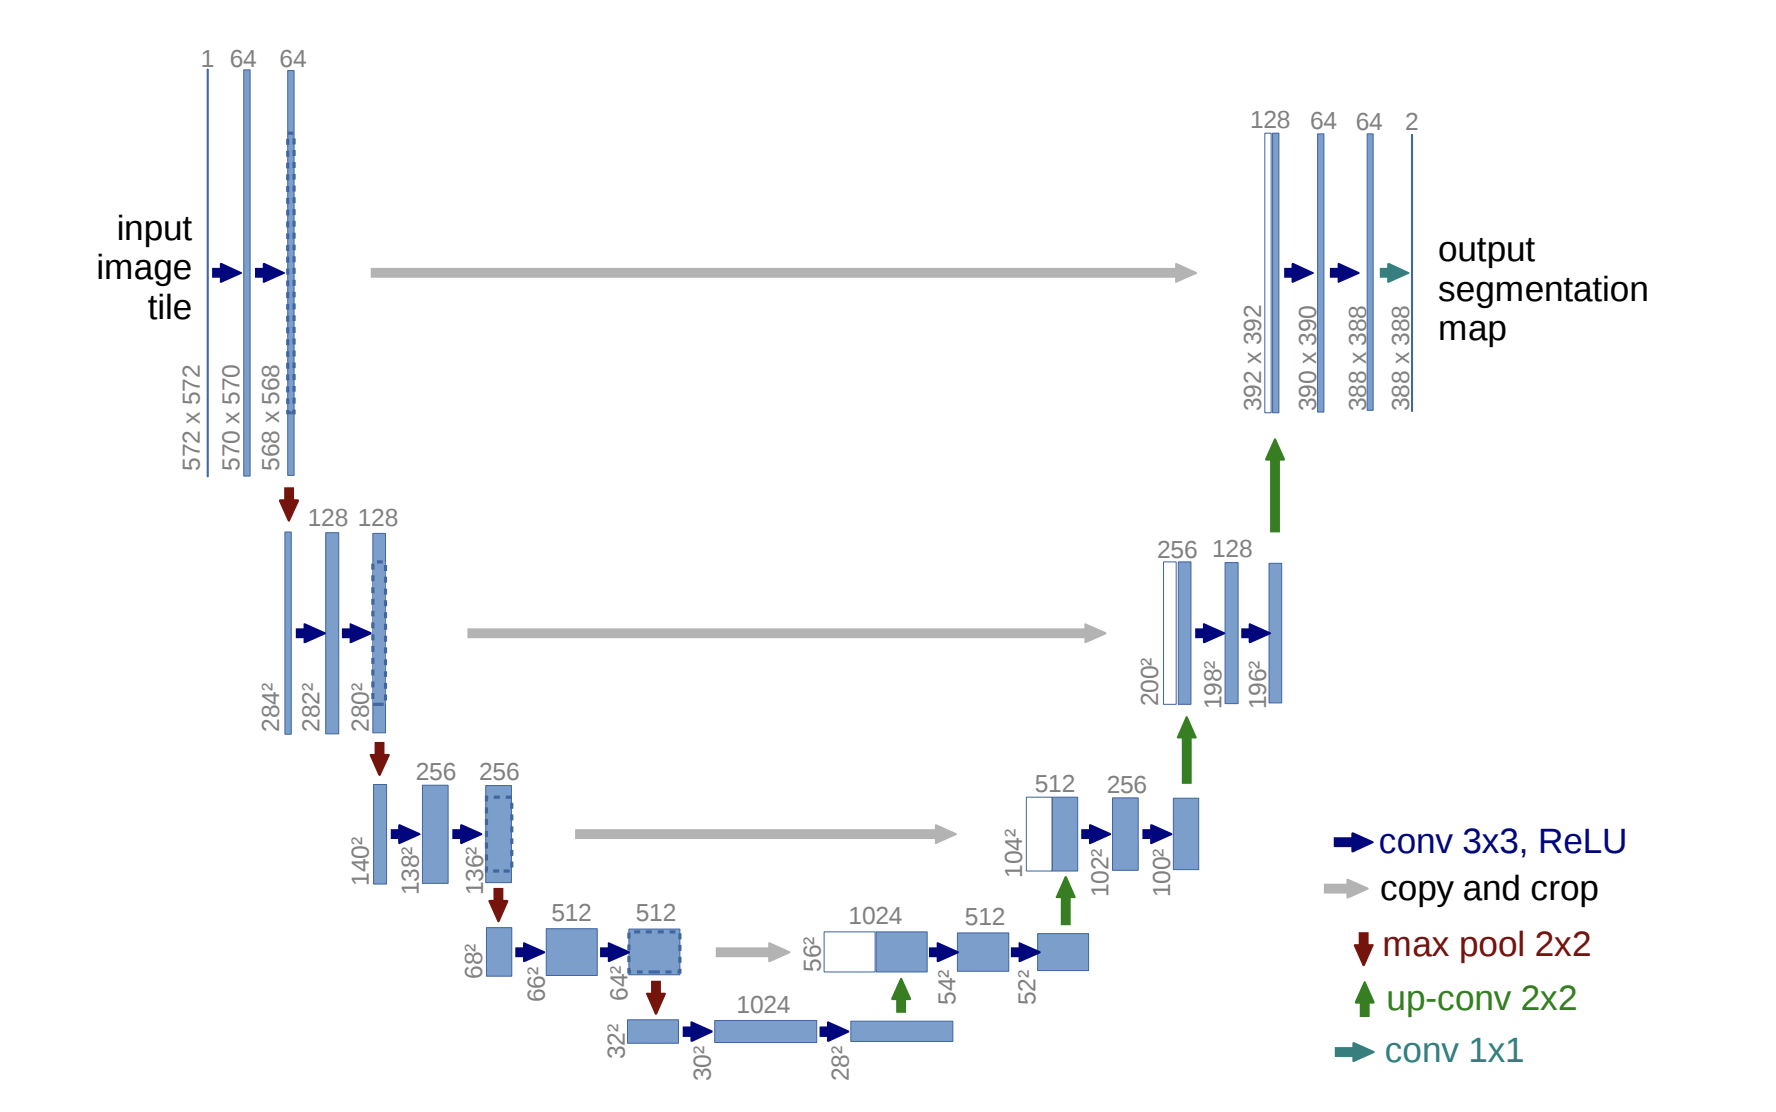

In [53]:
import torch.nn as nn
def UpDownConv(in_channels, mid_channels, out_channels):
    return nn.Sequential(
            *ConvRelu(in_channels, mid_channels, kernel_size=3, stride=1, padding=1 ),
            *ConvRelu(mid_channels, out_channels, kernel_size=3, stride=1, padding=1 ),
    )
def ConvRelu(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return [
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    ]
class UNet(nn.Module):
    
    def __init__(self, in_shape, num_classes):
        super(UNet, self).__init__()
        in_channels, height, width = in_shape

        self.down1 = nn.Sequential(
            *ConvRelu(in_channels, 16, kernel_size=3, stride=1, padding=1 ),
            *ConvRelu(16, 32, kernel_size=3, stride=2, padding=1 ),
        )
        #64
        self.down2 = UpDownConv(32, 64, 128)
        #32
        self.down3 = UpDownConv(128, 256, 512)
        #16
        self.down4 = UpDownConv(512, 512, 512)
        #8
        self.same = nn.Sequential(
            *ConvRelu(512,512, kernel_size=1, stride=1, padding=0 ),
        )
        #16
        self.up4 = UpDownConv(1024, 512, 512)
        #16
        self.up3 = UpDownConv(1024, 512, 128)
        #32
        self.up2 = UpDownConv(256, 128, 32)
        #64
        self.up1 = UpDownConv(64, 64, 32)
        #128

        self.up0 = nn.Sequential(
            *ConvRelu(32, 32, kernel_size=3, stride=1, padding=1 ),
        )
        #256

        self.classify = nn.Conv2d(32, num_classes, kernel_size=1, stride=1, padding=0 )

    def forward(self, x):

        down1 = self.down1(x)
        out   = F.max_pool2d(down1, kernel_size=2, stride=2) #64
        down2 = self.down2(out)
        out   = F.max_pool2d(down2, kernel_size=2, stride=2) #32
        down3 = self.down3(out)
        out   = F.max_pool2d(down3, kernel_size=2, stride=2) #16
        down4 = self.down4(out)
        out   = F.max_pool2d(down4, kernel_size=2, stride=2) # 8
        out   = self.same(out)
        out   = F.upsample(out, scale_factor=2, mode='bilinear') #16
        out   = torch.cat([down4, out],1)
        out   = self.up4(out)
        out   = F.upsample(out, scale_factor=2, mode='bilinear') #32
        out   = torch.cat([down3, out],1)
        out   = self.up3(out)
        out   = F.upsample(out, scale_factor=2, mode='bilinear') #64
        out   = torch.cat([down2, out],1)
        out   = self.up2(out)
        out   = F.upsample(out, scale_factor=2, mode='bilinear') #128
        out   = torch.cat([down1, out],1)
        out   = self.up1(out)
        out   = F.upsample(out, scale_factor=2, mode='bilinear') #256
        out   = self.up0(out)
        out   = self.classify(out)
        return out
    

In [11]:
num_classes = 1
batch_size  = 8
C = 3
from torch.autograd import Variable
import torch.nn.functional as F

inputs = torch.randn(batch_size,C,HIGHT,WIDTH)
labels = torch.LongTensor(batch_size,HIGHT,WIDTH).random_(1).type(torch.FloatTensor)

net = UNet(in_shape=(C,HIGHT,WIDTH), num_classes=1).train().cuda()
x = Variable(inputs).cuda()
y = Variable(labels).cuda()
logits = net.forward(x)

probs = F.sigmoid(logits)
probs_flat = probs.view (-1)
targets_flat = y.view(-1)
loss = nn.BCELoss().cuda()
output = loss(probs_flat, targets_flat)
output.backward()

print(type(net))
print(net)

<class '__main__.UNet'>
UNet(
  (down1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
  )
  (down2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
  )
  (down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d(256, 512

In [54]:
output

Variable containing:
 0.6076
[torch.cuda.FloatTensor of size 1 (GPU 0)]

### Soft Dice Loss implementation:

In [55]:
class DiceLoss(nn.Module):
    def __init__(self): 
        super(DiceLoss, self).__init__()

    def forward(self, input, target):
        smooth = 1.
        iflat = input.view(-1)
        tflat = target.view(-1)
        intersection = (iflat * tflat).sum()

        return 1 - ((2. * intersection + smooth) /
                    (iflat.sum() + tflat.sum() + smooth))

### Training prodecure 

In [56]:
import torch.optim as optim
LR = 0.0002
batch_size = 16
net = UNet(in_shape=(C,HIGHT,WIDTH), num_classes=1).train()
epochs = 100
cuda = True
ADAM = True


def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = LR * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
        
def train():
    if ADAM:
        optimizer = \
                    optim.Adam(net.parameters(),
                               lr= LR, betas=(0.5, 0.999))
    else:
        optimizer = \
                    optim.SGD(filter(lambda p: p.requires_grad, net.parameters()),
                              lr=0.01/iter_accum, momentum=0.9, weight_decay=0.0001)
        
    train_dataset = ImageMaskDataset(
                                'names', mode='train',
                                transform = data_aug)
    train_loader  = DataLoader(
                        train_dataset,
                        sampler = RandomSampler(train_dataset),
                        batch_size  = batch_size,
                        drop_last   = True,
                        num_workers = 8)
    
    i = 0
    if cuda:
        net.cuda()
    while  i < epochs:  
        sum_train_loss = 0.0
        sum_train_acc  = 0.0
        sum = 0
        net.train()
        optimizer.zero_grad()
        for index, data  in enumerate(train_loader):
            image,mask = data
            if cuda:
                tensors = Variable(image).cuda()
                masks   = Variable(mask).cuda()
            else:
                tensors = Variable(image)
                masks   = Variable(mask)
            logits  = net(tensors.float())
            probs   = F.sigmoid(logits)
            probs_flat = probs.view(-1)
            masks_flat = masks.view(-1)
            if cuda:
                loss = DiceLoss().cuda()
            else:
                loss = DiceLoss()
                
            output = loss(probs_flat, masks_flat.float())
            output.backward()
            optimizer.step()
            optimizer.zero_grad()
            adjust_learning_rate(optimizer, i)
            batch_loss = output.data[0]
            sum_train_loss += batch_loss
            print('\r epoch: %f| LR: %f|batch_loss:  %f  sum_train_loss: %f' % \
                  (i, LR, batch_loss, sum_train_loss), end='',flush=True)
        i = i +1
        images = tensors.data.cpu().numpy()
        masks  = masks.data.cpu().numpy()
        probs  = probs.data.cpu().numpy()

        image = images[0].transpose((1,2,0))*255
        mask  = (masks[0]*255).astype(np.uint8)
        print(mask.shape)
        prob  = np.squeeze((probs[0]*255).astype(np.uint8), axis=0)
        print(image.shape)
        print(prob.shape)
        image = image.astype(np.uint8)
        #mask  = mask.astype(np.uint8)[:, :, np.newaxis]*np.array([1,1,1],np.uint8)
        #prob  = prob.astype(np.uint8)[:, :, np.newaxis]*np.array([1,1,1],np.uint8)
        plt.subplot(131)
        plt.imshow(image)
        plt.subplot(132)
        plt.imshow(mask)
        plt.subplot(133)
        plt.imshow(prob)
        plt.show()


 epoch: 0.000000| LR: 0.000200|batch_loss:  0.616986  sum_train_loss: 58.928344(256, 256)
(256, 256, 3)
(256, 256)


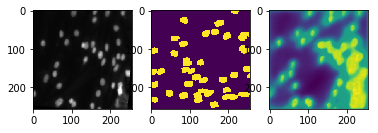

 epoch: 1.000000| LR: 0.000200|batch_loss:  0.688686  sum_train_loss: 57.474249(256, 256)
(256, 256, 3)
(256, 256)


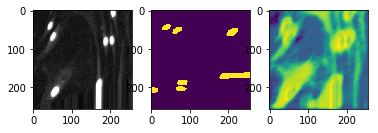

 epoch: 2.000000| LR: 0.000200|batch_loss:  0.662674  sum_train_loss: 56.001910(256, 256)
(256, 256, 3)
(256, 256)


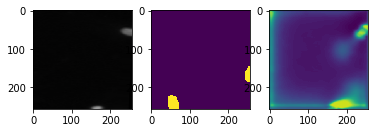

 epoch: 3.000000| LR: 0.000200|batch_loss:  0.671917  sum_train_loss: 55.080386(256, 256)
(256, 256, 3)
(256, 256)


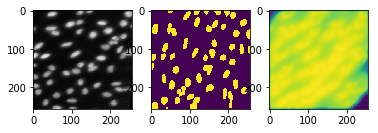

 epoch: 4.000000| LR: 0.000200|batch_loss:  0.570845  sum_train_loss: 54.638084(256, 256)
(256, 256, 3)
(256, 256)


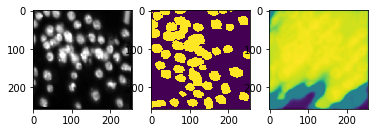

 epoch: 5.000000| LR: 0.000200|batch_loss:  0.614547  sum_train_loss: 52.627566(256, 256)
(256, 256, 3)
(256, 256)


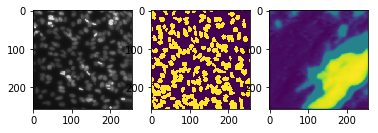

 epoch: 6.000000| LR: 0.000200|batch_loss:  0.508684  sum_train_loss: 52.117694(256, 256)
(256, 256, 3)
(256, 256)


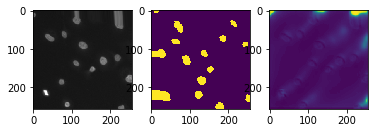

 epoch: 7.000000| LR: 0.000200|batch_loss:  0.574023  sum_train_loss: 50.551805(256, 256)
(256, 256, 3)
(256, 256)


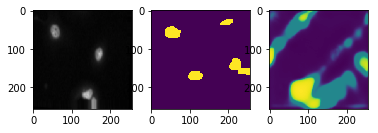

 epoch: 8.000000| LR: 0.000200|batch_loss:  0.598359  sum_train_loss: 50.325249(256, 256)
(256, 256, 3)
(256, 256)


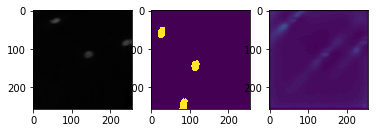

 epoch: 9.000000| LR: 0.000200|batch_loss:  0.496264  sum_train_loss: 49.827638(256, 256)
(256, 256, 3)
(256, 256)


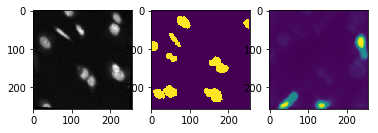

 epoch: 10.000000| LR: 0.000200|batch_loss:  0.512297  sum_train_loss: 49.044437(256, 256)
(256, 256, 3)
(256, 256)


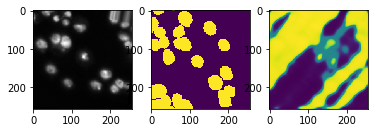

 epoch: 11.000000| LR: 0.000200|batch_loss:  0.551678  sum_train_loss: 48.484143(256, 256)
(256, 256, 3)
(256, 256)


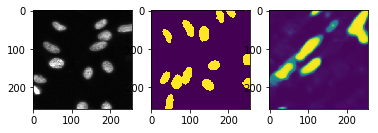

 epoch: 12.000000| LR: 0.000200|batch_loss:  0.546992  sum_train_loss: 47.450864(256, 256)
(256, 256, 3)
(256, 256)


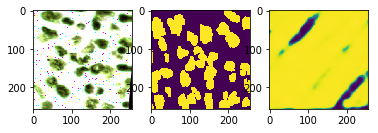

 epoch: 13.000000| LR: 0.000200|batch_loss:  0.570693  sum_train_loss: 47.131160(256, 256)
(256, 256, 3)
(256, 256)


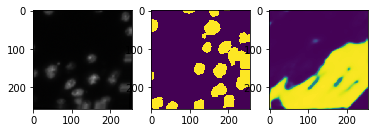

 epoch: 14.000000| LR: 0.000200|batch_loss:  0.526138  sum_train_loss: 46.141484(256, 256)
(256, 256, 3)
(256, 256)


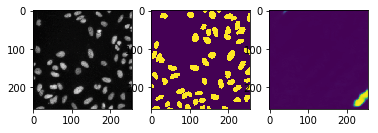

 epoch: 15.000000| LR: 0.000200|batch_loss:  0.616796  sum_train_loss: 46.579203(256, 256)
(256, 256, 3)
(256, 256)


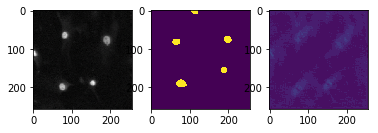

 epoch: 16.000000| LR: 0.000200|batch_loss:  0.554261  sum_train_loss: 46.324255(256, 256)
(256, 256, 3)
(256, 256)


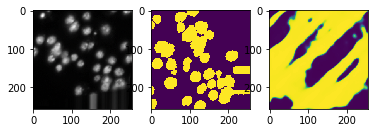

 epoch: 17.000000| LR: 0.000200|batch_loss:  0.569111  sum_train_loss: 45.532880(256, 256)
(256, 256, 3)
(256, 256)


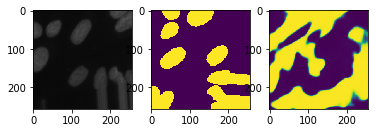

 epoch: 18.000000| LR: 0.000200|batch_loss:  0.423588  sum_train_loss: 45.056439(256, 256)
(256, 256, 3)
(256, 256)


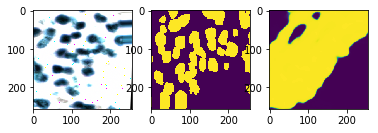

 epoch: 19.000000| LR: 0.000200|batch_loss:  0.608315  sum_train_loss: 44.247537(256, 256)
(256, 256, 3)
(256, 256)


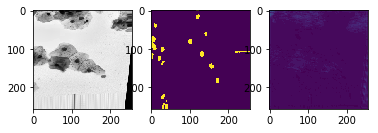

 epoch: 20.000000| LR: 0.000200|batch_loss:  0.528039  sum_train_loss: 44.395596(256, 256)
(256, 256, 3)
(256, 256)


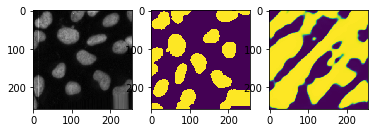

 epoch: 21.000000| LR: 0.000200|batch_loss:  0.519304  sum_train_loss: 43.080203(256, 256)
(256, 256, 3)
(256, 256)


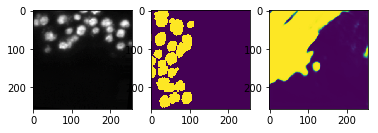

 epoch: 22.000000| LR: 0.000200|batch_loss:  0.573202  sum_train_loss: 41.937202(256, 256)
(256, 256, 3)
(256, 256)


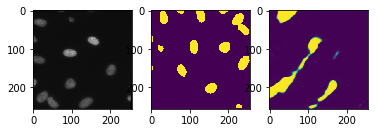

 epoch: 23.000000| LR: 0.000200|batch_loss:  0.481296  sum_train_loss: 41.169747(256, 256)
(256, 256, 3)
(256, 256)


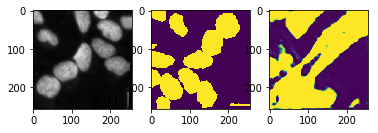

 epoch: 24.000000| LR: 0.000200|batch_loss:  0.513076  sum_train_loss: 40.098455(256, 256)
(256, 256, 3)
(256, 256)


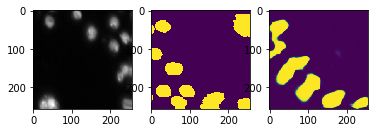

 epoch: 25.000000| LR: 0.000200|batch_loss:  0.415485  sum_train_loss: 38.600109(256, 256)
(256, 256, 3)
(256, 256)


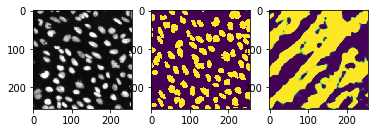

 epoch: 26.000000| LR: 0.000200|batch_loss:  0.472794  sum_train_loss: 37.872385(256, 256)
(256, 256, 3)
(256, 256)


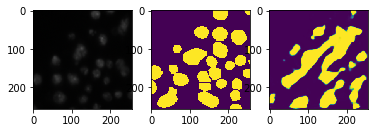

 epoch: 27.000000| LR: 0.000200|batch_loss:  0.388049  sum_train_loss: 37.535996(256, 256)
(256, 256, 3)
(256, 256)


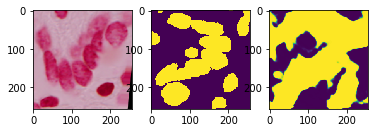

 epoch: 28.000000| LR: 0.000200|batch_loss:  0.518522  sum_train_loss: 35.905080(256, 256)
(256, 256, 3)
(256, 256)


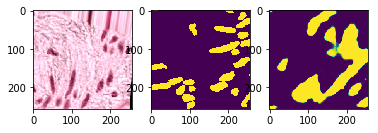

 epoch: 29.000000| LR: 0.000200|batch_loss:  0.429352  sum_train_loss: 35.014745(256, 256)
(256, 256, 3)
(256, 256)


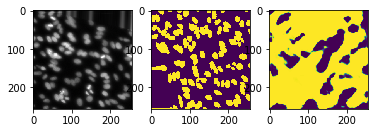

 epoch: 30.000000| LR: 0.000200|batch_loss:  0.537062  sum_train_loss: 33.549507(256, 256)
(256, 256, 3)
(256, 256)


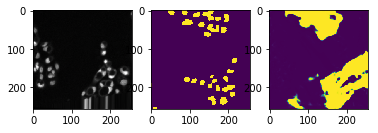

 epoch: 31.000000| LR: 0.000200|batch_loss:  0.393142  sum_train_loss: 32.486708(256, 256)
(256, 256, 3)
(256, 256)


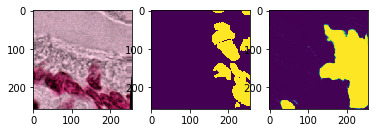

 epoch: 32.000000| LR: 0.000200|batch_loss:  0.378674  sum_train_loss: 32.557751(256, 256)
(256, 256, 3)
(256, 256)


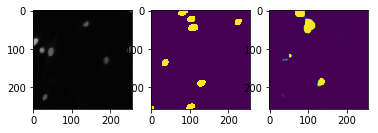

 epoch: 33.000000| LR: 0.000200|batch_loss:  0.422388  sum_train_loss: 32.689097(256, 256)
(256, 256, 3)
(256, 256)


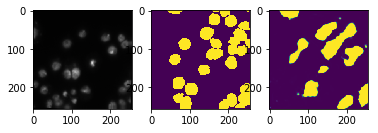

 epoch: 34.000000| LR: 0.000200|batch_loss:  0.472340  sum_train_loss: 32.514338(256, 256)
(256, 256, 3)
(256, 256)


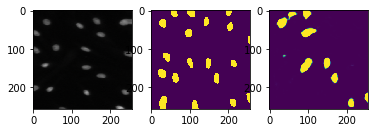

 epoch: 35.000000| LR: 0.000200|batch_loss:  0.456000  sum_train_loss: 32.030892(256, 256)
(256, 256, 3)
(256, 256)


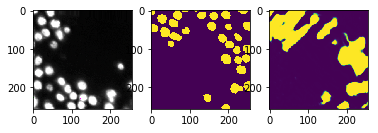

 epoch: 36.000000| LR: 0.000200|batch_loss:  0.352302  sum_train_loss: 32.166725(256, 256)
(256, 256, 3)
(256, 256)


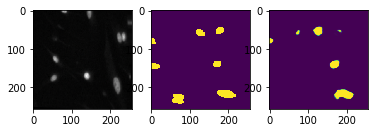

 epoch: 37.000000| LR: 0.000200|batch_loss:  0.456829  sum_train_loss: 32.472872(256, 256)
(256, 256, 3)
(256, 256)


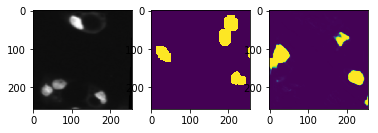

 epoch: 38.000000| LR: 0.000200|batch_loss:  0.411027  sum_train_loss: 31.760452(256, 256)
(256, 256, 3)
(256, 256)


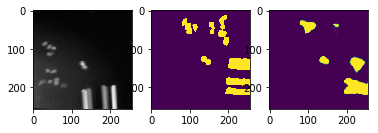

 epoch: 39.000000| LR: 0.000200|batch_loss:  0.353658  sum_train_loss: 30.986901(256, 256)
(256, 256, 3)
(256, 256)


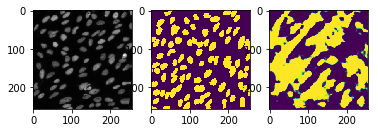

 epoch: 40.000000| LR: 0.000200|batch_loss:  0.298168  sum_train_loss: 31.448609(256, 256)
(256, 256, 3)
(256, 256)


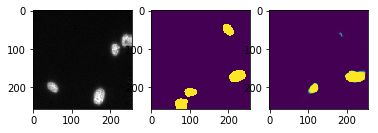

 epoch: 41.000000| LR: 0.000200|batch_loss:  0.390049  sum_train_loss: 30.921603(256, 256)
(256, 256, 3)
(256, 256)


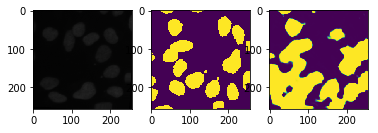

 epoch: 42.000000| LR: 0.000200|batch_loss:  0.318515  sum_train_loss: 30.847592(256, 256)
(256, 256, 3)
(256, 256)


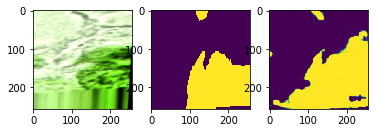

 epoch: 43.000000| LR: 0.000200|batch_loss:  0.472105  sum_train_loss: 31.023780(256, 256)
(256, 256, 3)
(256, 256)


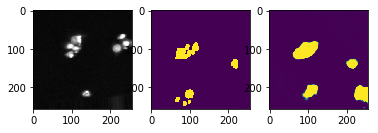

 epoch: 44.000000| LR: 0.000200|batch_loss:  0.321890  sum_train_loss: 30.089368(256, 256)
(256, 256, 3)
(256, 256)


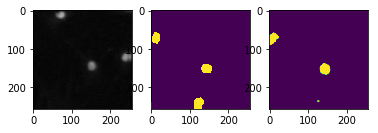

 epoch: 45.000000| LR: 0.000200|batch_loss:  0.418615  sum_train_loss: 30.275547(256, 256)
(256, 256, 3)
(256, 256)


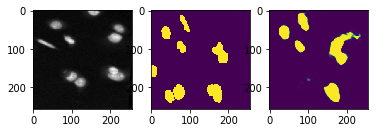

 epoch: 46.000000| LR: 0.000200|batch_loss:  0.353153  sum_train_loss: 30.428521(256, 256)
(256, 256, 3)
(256, 256)


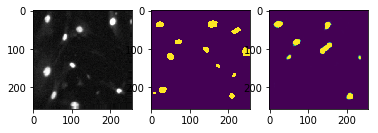

 epoch: 47.000000| LR: 0.000200|batch_loss:  0.338366  sum_train_loss: 30.287460(256, 256)
(256, 256, 3)
(256, 256)


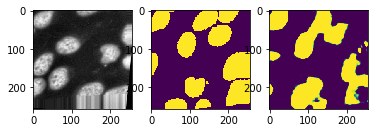

 epoch: 48.000000| LR: 0.000200|batch_loss:  0.438742  sum_train_loss: 30.103298(256, 256)
(256, 256, 3)
(256, 256)


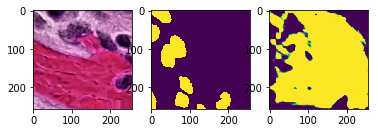

 epoch: 49.000000| LR: 0.000200|batch_loss:  0.295172  sum_train_loss: 29.701651(256, 256)
(256, 256, 3)
(256, 256)


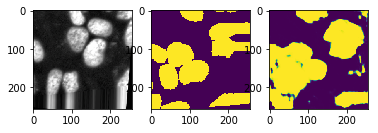

 epoch: 50.000000| LR: 0.000200|batch_loss:  0.337835  sum_train_loss: 29.567281(256, 256)
(256, 256, 3)
(256, 256)


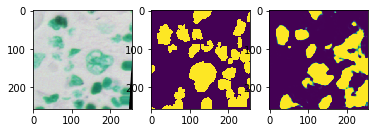

 epoch: 51.000000| LR: 0.000200|batch_loss:  0.391603  sum_train_loss: 30.221687(256, 256)
(256, 256, 3)
(256, 256)


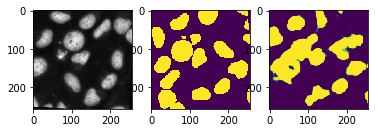

 epoch: 52.000000| LR: 0.000200|batch_loss:  0.406502  sum_train_loss: 29.580307(256, 256)
(256, 256, 3)
(256, 256)


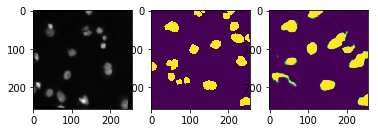

 epoch: 53.000000| LR: 0.000200|batch_loss:  0.378469  sum_train_loss: 29.856391(256, 256)
(256, 256, 3)
(256, 256)


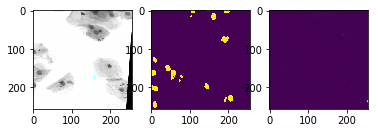

 epoch: 54.000000| LR: 0.000200|batch_loss:  0.308073  sum_train_loss: 29.475467(256, 256)
(256, 256, 3)
(256, 256)


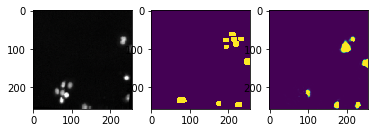

 epoch: 55.000000| LR: 0.000200|batch_loss:  0.393621  sum_train_loss: 29.861358(256, 256)
(256, 256, 3)
(256, 256)


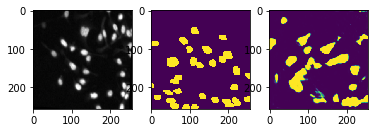

 epoch: 56.000000| LR: 0.000200|batch_loss:  0.365323  sum_train_loss: 29.213698(256, 256)
(256, 256, 3)
(256, 256)


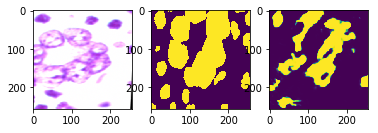

 epoch: 57.000000| LR: 0.000200|batch_loss:  0.352277  sum_train_loss: 28.874569(256, 256)
(256, 256, 3)
(256, 256)


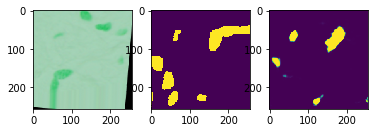

 epoch: 58.000000| LR: 0.000200|batch_loss:  0.340240  sum_train_loss: 29.379899(256, 256)
(256, 256, 3)
(256, 256)


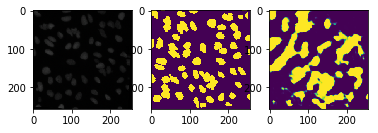

 epoch: 59.000000| LR: 0.000200|batch_loss:  0.296132  sum_train_loss: 29.092420(256, 256)
(256, 256, 3)
(256, 256)


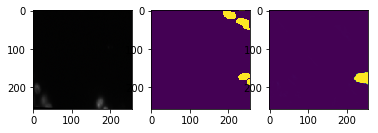

 epoch: 60.000000| LR: 0.000200|batch_loss:  0.294027  sum_train_loss: 29.086006(256, 256)
(256, 256, 3)
(256, 256)


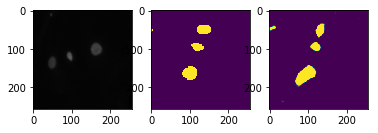

 epoch: 61.000000| LR: 0.000200|batch_loss:  0.302224  sum_train_loss: 28.783340(256, 256)
(256, 256, 3)
(256, 256)


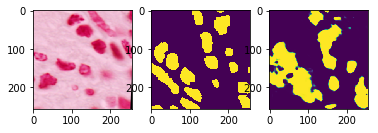

 epoch: 62.000000| LR: 0.000200|batch_loss:  0.357005  sum_train_loss: 28.587156(256, 256)
(256, 256, 3)
(256, 256)


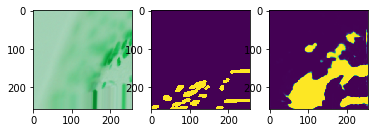

 epoch: 63.000000| LR: 0.000200|batch_loss:  0.336751  sum_train_loss: 28.999309(256, 256)
(256, 256, 3)
(256, 256)


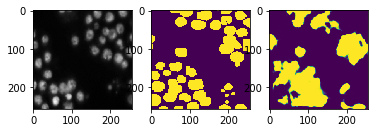

 epoch: 64.000000| LR: 0.000200|batch_loss:  0.399750  sum_train_loss: 29.078104(256, 256)
(256, 256, 3)
(256, 256)


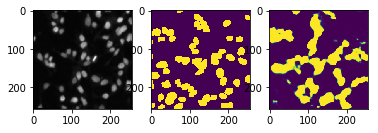

 epoch: 65.000000| LR: 0.000200|batch_loss:  0.305689  sum_train_loss: 28.344498(256, 256)
(256, 256, 3)
(256, 256)


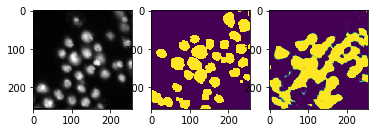

 epoch: 66.000000| LR: 0.000200|batch_loss:  0.312221  sum_train_loss: 28.775385(256, 256)
(256, 256, 3)
(256, 256)


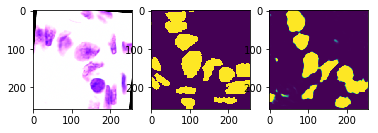

 epoch: 67.000000| LR: 0.000200|batch_loss:  0.437348  sum_train_loss: 28.692486(256, 256)
(256, 256, 3)
(256, 256)


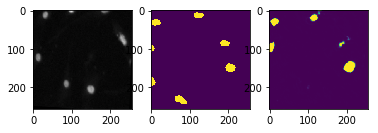

 epoch: 68.000000| LR: 0.000200|batch_loss:  0.309929  sum_train_loss: 28.972811(256, 256)
(256, 256, 3)
(256, 256)


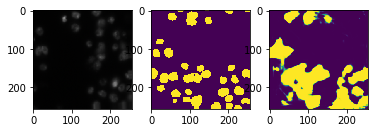

 epoch: 69.000000| LR: 0.000200|batch_loss:  0.378301  sum_train_loss: 28.743384(256, 256)
(256, 256, 3)
(256, 256)


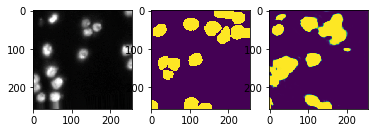

 epoch: 70.000000| LR: 0.000200|batch_loss:  0.446817  sum_train_loss: 28.272129(256, 256)
(256, 256, 3)
(256, 256)


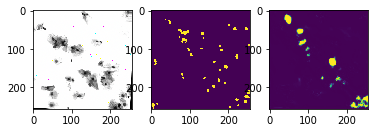

 epoch: 71.000000| LR: 0.000200|batch_loss:  0.327236  sum_train_loss: 28.651154(256, 256)
(256, 256, 3)
(256, 256)


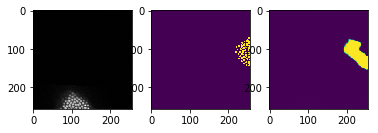

 epoch: 72.000000| LR: 0.000200|batch_loss:  0.397770  sum_train_loss: 28.867054(256, 256)
(256, 256, 3)
(256, 256)


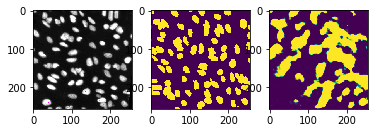

 epoch: 73.000000| LR: 0.000200|batch_loss:  0.393367  sum_train_loss: 28.741901(256, 256)
(256, 256, 3)
(256, 256)


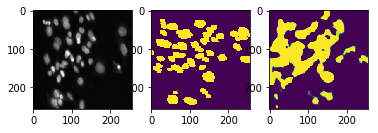

 epoch: 74.000000| LR: 0.000200|batch_loss:  0.429333  sum_train_loss: 28.903357(256, 256)
(256, 256, 3)
(256, 256)


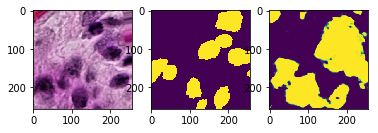

 epoch: 75.000000| LR: 0.000200|batch_loss:  0.384763  sum_train_loss: 28.694812(256, 256)
(256, 256, 3)
(256, 256)


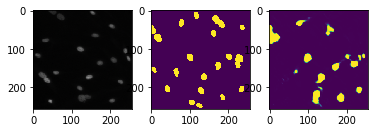

 epoch: 76.000000| LR: 0.000200|batch_loss:  0.293372  sum_train_loss: 29.128902(256, 256)
(256, 256, 3)
(256, 256)


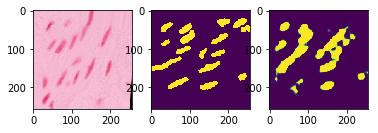

 epoch: 77.000000| LR: 0.000200|batch_loss:  0.468856  sum_train_loss: 28.562241(256, 256)
(256, 256, 3)
(256, 256)


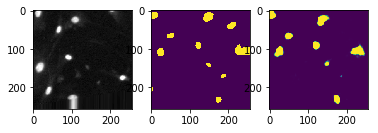

 epoch: 78.000000| LR: 0.000200|batch_loss:  0.317982  sum_train_loss: 28.432309(256, 256)
(256, 256, 3)
(256, 256)


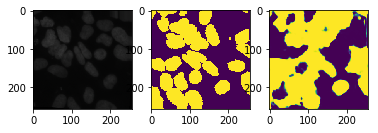

 epoch: 79.000000| LR: 0.000200|batch_loss:  0.304717  sum_train_loss: 28.498399(256, 256)
(256, 256, 3)
(256, 256)


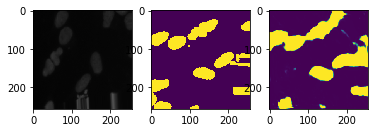

 epoch: 80.000000| LR: 0.000200|batch_loss:  0.338336  sum_train_loss: 28.661903(256, 256)
(256, 256, 3)
(256, 256)


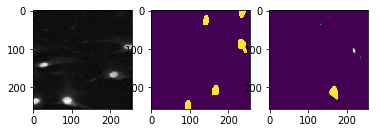

 epoch: 81.000000| LR: 0.000200|batch_loss:  0.377487  sum_train_loss: 28.114250(256, 256)
(256, 256, 3)
(256, 256)


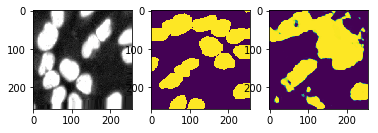

 epoch: 82.000000| LR: 0.000200|batch_loss:  0.274147  sum_train_loss: 28.422393(256, 256)
(256, 256, 3)
(256, 256)


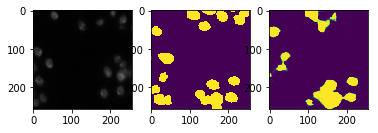

 epoch: 83.000000| LR: 0.000200|batch_loss:  0.302778  sum_train_loss: 28.768492(256, 256)
(256, 256, 3)
(256, 256)


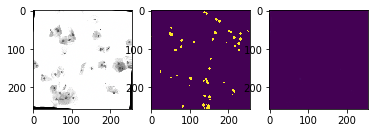

 epoch: 84.000000| LR: 0.000200|batch_loss:  0.374857  sum_train_loss: 28.800467(256, 256)
(256, 256, 3)
(256, 256)


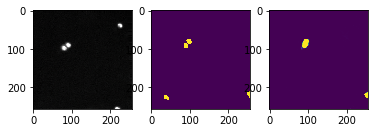

 epoch: 85.000000| LR: 0.000200|batch_loss:  0.320602  sum_train_loss: 28.187789(256, 256)
(256, 256, 3)
(256, 256)


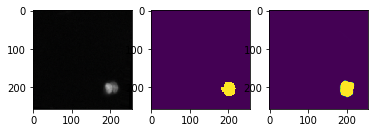

 epoch: 86.000000| LR: 0.000200|batch_loss:  0.290472  sum_train_loss: 28.599949(256, 256)
(256, 256, 3)
(256, 256)


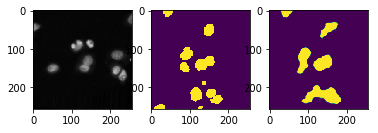

 epoch: 87.000000| LR: 0.000200|batch_loss:  0.251712  sum_train_loss: 28.672851(256, 256)
(256, 256, 3)
(256, 256)


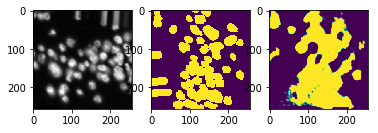

 epoch: 88.000000| LR: 0.000200|batch_loss:  0.271339  sum_train_loss: 28.474295(256, 256)
(256, 256, 3)
(256, 256)


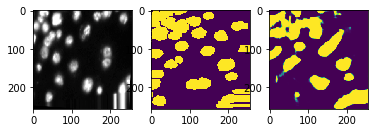

 epoch: 89.000000| LR: 0.000200|batch_loss:  0.305213  sum_train_loss: 28.047478(256, 256)
(256, 256, 3)
(256, 256)


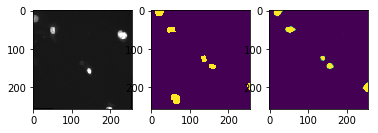

 epoch: 90.000000| LR: 0.000200|batch_loss:  0.397550  sum_train_loss: 28.245691(256, 256)
(256, 256, 3)
(256, 256)


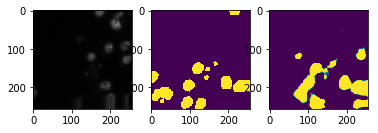

 epoch: 91.000000| LR: 0.000200|batch_loss:  0.339595  sum_train_loss: 28.586203(256, 256)
(256, 256, 3)
(256, 256)


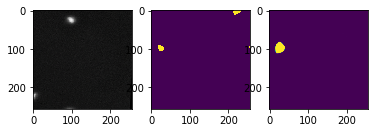

 epoch: 92.000000| LR: 0.000200|batch_loss:  0.312341  sum_train_loss: 28.865128(256, 256)
(256, 256, 3)
(256, 256)


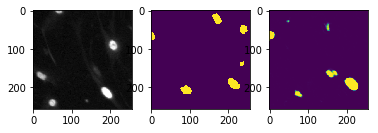

 epoch: 93.000000| LR: 0.000200|batch_loss:  0.347359  sum_train_loss: 28.223041(256, 256)
(256, 256, 3)
(256, 256)


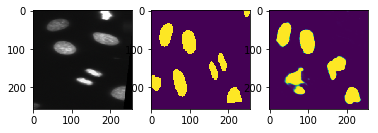

 epoch: 94.000000| LR: 0.000200|batch_loss:  0.326717  sum_train_loss: 28.167603(256, 256)
(256, 256, 3)
(256, 256)


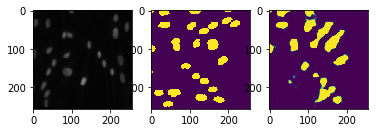

 epoch: 95.000000| LR: 0.000200|batch_loss:  0.311837  sum_train_loss: 28.199560(256, 256)
(256, 256, 3)
(256, 256)


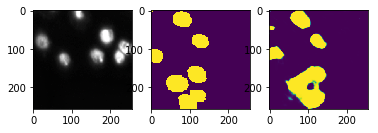

 epoch: 96.000000| LR: 0.000200|batch_loss:  0.379949  sum_train_loss: 29.123891(256, 256)
(256, 256, 3)
(256, 256)


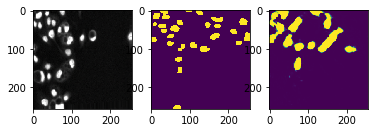

 epoch: 97.000000| LR: 0.000200|batch_loss:  0.340616  sum_train_loss: 28.517648(256, 256)
(256, 256, 3)
(256, 256)


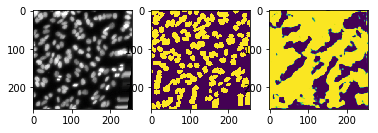

 epoch: 98.000000| LR: 0.000200|batch_loss:  0.313309  sum_train_loss: 28.539596(256, 256)
(256, 256, 3)
(256, 256)


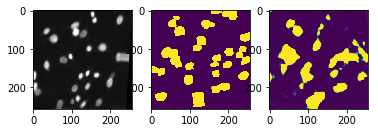

 epoch: 99.000000| LR: 0.000200|batch_loss:  0.418113  sum_train_loss: 28.386595(256, 256)
(256, 256, 3)
(256, 256)


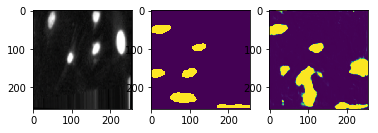

In [57]:
import warnings
warnings.filterwarnings('ignore')
train()

In [58]:
import torch 
torch.save(net.state_dict(), DATA_DIR +'/checkpoint/model_2.pth')